In [1]:
import os
from collections import Counter

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from tensorflow import keras, config
# Configure GPU memory to run alongside other training tasks
gpus = config.experimental.list_physical_devices('GPU')
config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 8 = 8GB
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings
from keras.models import load_model

from cascid.datasets.pad_ufes.database import get_images_with_no_metadata
from cascid.datasets.isic.database import get_train_test_images_raw, get_train_test_images_hairless, get_train_test_images_hairless_quantized
from cascid.datasets.pad_ufes import images as pad_ufes_images, database as pad_ufes_db
from cascid.configs.config import DATA_DIR

2022-11-25 08:41:20.899839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 08:41:21.104653: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 08:41:21.829604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-25 08:41:21.829688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## PAD-UFES

In [2]:
pad_ufes_vals_raw = dict()
pad_ufes_vals_hairless = dict()
pad_ufes_vals_hq = dict()
# df
categories = [np.array(sorted(['Cancer', "Not"]), dtype='object')]
ohe = OneHotEncoder(sparse=False, categories=categories, handle_unknown="ignore")

_, pad_ufes_vals_raw['x_test'], _, pad_ufes_vals_raw['y_test'] = pad_ufes_db.get_train_test_images_raw()
pad_ufes_vals_raw['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_raw['y_test'].flatten()]
ohe.fit(np.array(pad_ufes_vals_raw['y_test']).reshape(-1,1))

_, pad_ufes_vals_hairless['x_test'], _, pad_ufes_vals_hairless['y_test'] = pad_ufes_db.get_train_test_images_hairless()
pad_ufes_vals_hairless['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_hairless['y_test'].flatten()]

_, pad_ufes_vals_hq['x_test'], _, pad_ufes_vals_hq['y_test'] = pad_ufes_db.get_train_test_images_hairless_quantized()
pad_ufes_vals_hq['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_hq['y_test'].flatten()]

## ISIC

In [3]:
isic_vals_raw = dict()
# df
_, isic_vals_raw['x_test'], _, isic_vals_raw['y_test'] = get_train_test_images_raw()
isic_vals_raw['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_raw['y_test'].flatten()))

isic_vals_hairless = dict()
# df
_, isic_vals_hairless['x_test'], _, isic_vals_hairless['y_test'] = get_train_test_images_hairless()
isic_vals_hairless['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_hairless['y_test'].flatten()))

isic_vals_hq = dict()
# df
_, isic_vals_hq['x_test'], _, isic_vals_hq['y_test'] = get_train_test_images_hairless_quantized()
isic_vals_hq['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_hq['y_test'].flatten()))

## Evaluation

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    
    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.3f' if normalize else 'd'
    thresh = cm.mean()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [15]:
def evaluate_model_performance(model: keras.models.Sequential, x_test, y_test, show_matrix=False):
    y_pred = model.predict(x_test, verbose=0)
    y_pred = ohe.inverse_transform(y_pred).flatten()
    acc = accuracy_score(y_test, y_pred)
    if acc < 0.5:
        y_pred_fixed = ["Not" if x == "Cancer" else "Cancer" for x in y_pred]
        acc = 1-acc
    else:
        y_pred_fixed = y_pred

    # # print("Model accuracy for {}: {:.3f}%".format(title, 100*acc))
    if show_matrix:
        plot_confusion_matrix(
            y_true=y_test,
            y_pred=y_pred_fixed,
            classes=ohe.categories_[0].tolist(),
            normalize=True,
            title="Confusion matrix"
        );
    return acc

In [24]:
history = dict()

EXPERIMENT_DIR = DATA_DIR / 'experiments_final' / 'final_isic'
tops = os.listdir(EXPERIMENT_DIR)
for top in tops:
    models = os.listdir(EXPERIMENT_DIR / top)
    for mod in models:
        history[mod] = []
        checkpoints = sorted(list((EXPERIMENT_DIR / top / mod).glob('*checkpoint*')))
        for chk in checkpoints:
            epoch = int(str(chk)[-4:])
            loaded = load_model(EXPERIMENT_DIR / top / mod / chk)
            if mod == 'aug_hq':
                acc_isic = evaluate_model_performance(loaded, **isic_vals_hq)
                acc_pad = evaluate_model_performance(loaded, **pad_ufes_vals_hq)
            elif mod == 'aug_raw':
                acc_isic = evaluate_model_performance(loaded, **isic_vals_raw)
                acc_pad = evaluate_model_performance(loaded, **pad_ufes_vals_raw)
            else: # 'aug_hairless'
                acc_isic = evaluate_model_performance(loaded, **isic_vals_hairless)
                acc_pad = evaluate_model_performance(loaded, **pad_ufes_vals_hairless)
            # EPOCH, acc_isic, acc_pad
            history[mod].append([epoch, acc_isic, acc_pad])

2022-11-23 09:40:05.405081: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 474808320 exceeds 10% of free system memory.
2022-11-23 09:40:05.941526: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 474808320 exceeds 10% of free system memory.
2022-11-23 09:40:07.308498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-23 09:40:07.829612: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-23 09:40:20.986535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 474808320 exceeds 10% of free system memory.
2022-11-23 09:40:21.498164: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 474808320 exceeds 10

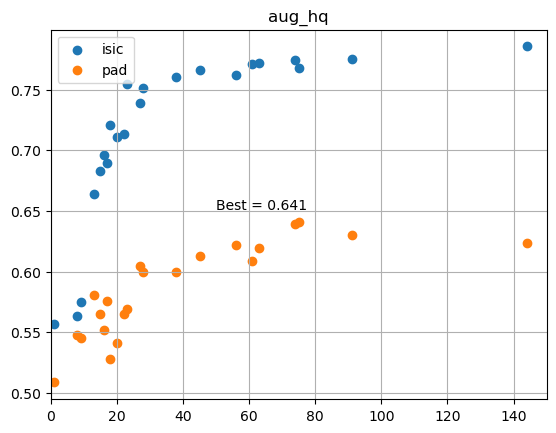

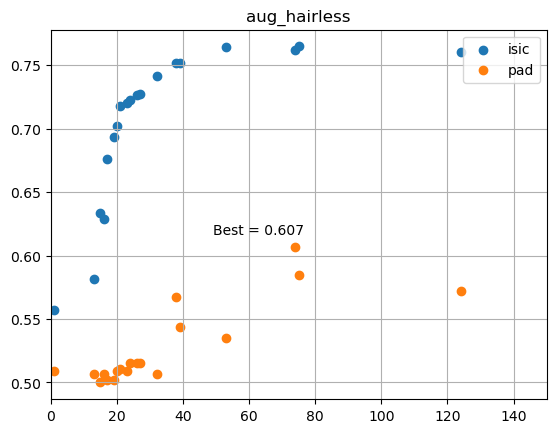

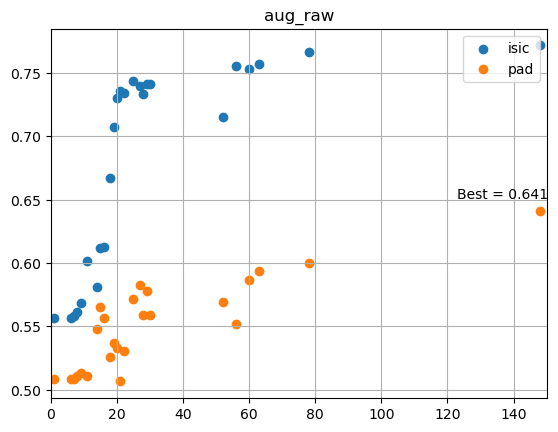

In [40]:
for k,v in history.items():
    v = np.array(v)
    x = v[:,0]
    isic = v[:,1]
    pad = v[:,2]
    best_pad = np.argmax(pad)
    plt.scatter(x, isic, label='isic')
    plt.scatter(x, pad, label='pad')
    plt.annotate("Best = {:.3f}".format(pad[best_pad]), (x[best_pad]-25, pad[best_pad]+0.01))
    plt.xlim((-0.05,150.05))
    plt.title(k)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
fine_tun_model = DATA_DIR / 'experiments_fine_tuning' / 'final_isic' / 'resnet34' / 'aug_hq'
model = load_model(fine_tun_model)

2022-11-25 08:44:49.051418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 08:44:49.052040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 08:44:49.053018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 08:44:49.053597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(0.6322981366459627, 0.6826086956521739)

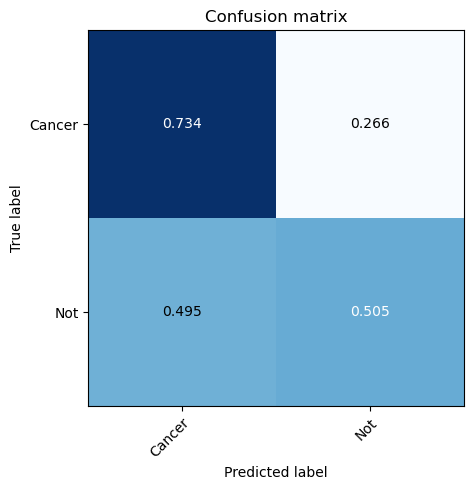

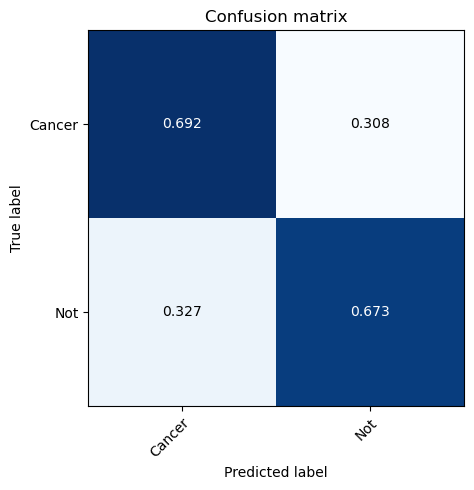

In [19]:
evaluate_model_performance(model, **isic_vals_hq, show_matrix=True), evaluate_model_performance(model, **pad_ufes_vals_hq, show_matrix=True)